In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib import gridspec
from scipy.sparse import diags

In [2]:
def solve_advect(tau,N,L,c,tMax,f0,method='ftcs'):
    '''Function to solve the advection equation'''
    h=L/N
    coeff=c*tau/(2.0*h)
    
    # Initialize a
    xlin=np.linspace(0,L,N)
    a=np.zeros((tMax,N))
    a[0,:]=f0(xlin)
    
    # Get grids, helpful for plotting
    tlin=np.linspace(0,tMax,tMax)
    x,t=np.meshgrid(xlin,tlin)        


    # Propagate advection equation
    for i in range(tMax-1):
        
        if method=='ftcs':
            a[i+1,1:N-1] = a[i,1:N-1]-coeff*(a[i,2:N]-a[i,0:N-2])
            # Apply periodic boundary conditions
            a[i+1,0] = a[i,0]-coeff*(a[i,1]-a[i,-1])
            a[i+1,N-1] = a[i,N-1]-coeff*(a[i,0]-a[i,N-2])
        
        elif method=='lax':
            a[i+1,1:N-1] = 0.5*(a[i,2:N]+a[i,0:N-2])-coeff*(a[i,2:N]-a[i,0:N-2])
            a[i+1,0] = 0.5*(a[i,1]+a[i,-1])-coeff*(a[i,1]-a[i,-1])
            a[i+1,N-1] = 0.5*(a[i,0]+a[i,N-2])-coeff*(a[i,0]-a[i,N-2])
            
        elif method=='lax_wendroff':
            a[i+1,1:N-1] = a[i,1:N-1]-coeff*(a[i,2:N]-a[i,0:N-2]) \
                            +2.*coeff**2*(a[i,2:N]+a[i,0:N-2]-2.*a[i,1:N-1])
            
            a[i+1,0] = a[i,0]-coeff*(a[i,1]-a[i,-1]) \
                            +2.*coeff**2*(a[i,1]+a[i,-1]-2.*a[i,0])
            
            
            a[i+1,N-1] = a[i,N-1]-coeff*(a[i,0]-a[i,N-2]) \
                            +2.*coeff**2*(a[i,0]+a[i,N-2]-2.*a[i,N-1])

            
    return xlin,tlin,x,t,a

def cos_wave_packet(x):
    '''Function for wavepacket'''
    sigma=0.1
    k=np.pi/sigma
    x0=0.5
    return np.cos(k*(x-x0))*np.exp(-(x-x0)**2/(2*sigma)**2)

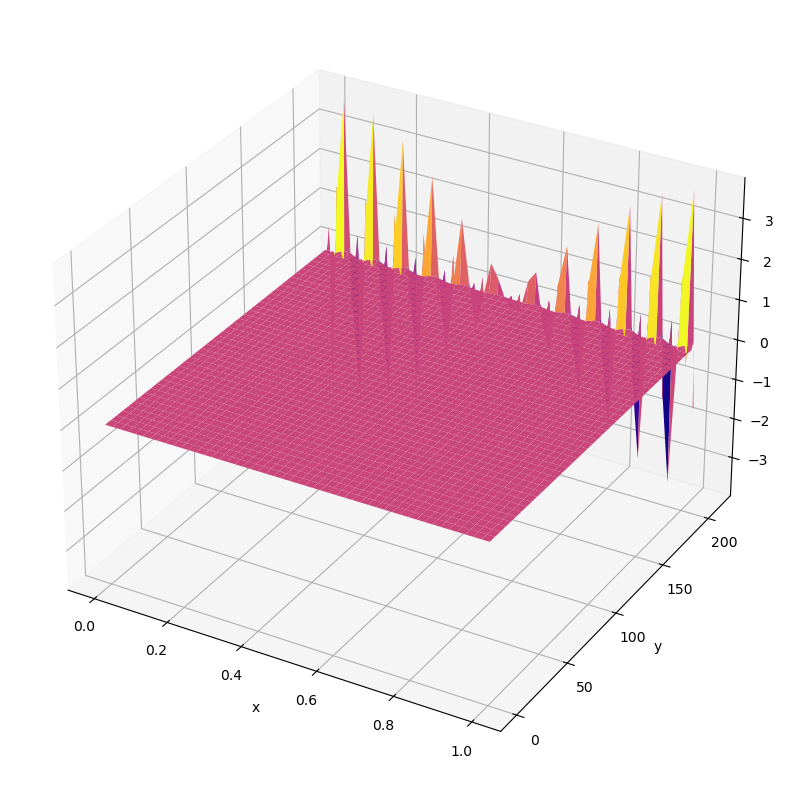

In [3]:
# Parameters for advection equation and calculation
tau=0.05
N=50
L=1.
c=1.
tMax=10*(int(np.ceil(L/(c*tau)))+1) # One period so should come back to itself
mycmap=cm.plasma

# Solve using the FTCS method
xlin,tlin,x,t,a=solve_advect(tau,N,L,c,tMax,cos_wave_packet,method='ftcs')

# Plots
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
#ax1 = fig.add_subplot(1, 3, 2,)
#ax2 = fig.add_subplot(1, 3, 3,)

# 3D plot:
ax0.plot_surface(x,t,a,cmap=mycmap)
# Contour plot:
#CS_gs=ax1.contour(x,y,phi)
#ax1.clabel(CS_gs)


# Label axes
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('a')

# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# ax2.set_xlabel('x')
# ax2.set_ylabel('y')

plt.savefig('ftcs_advect_div.pdf',bbox_inches='tight')
plt.show()


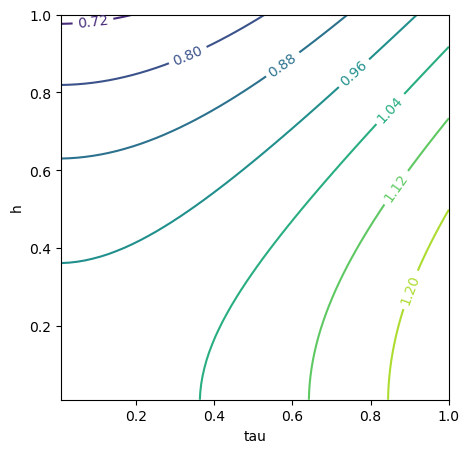

In [4]:
c=1
k=np.pi/4
tauLin=np.linspace(0.01,1,50)
hLin=np.linspace(0.01,1,50)

tau,h=np.meshgrid(tauLin,hLin)

xi=np.sqrt(np.cos(k*h)**2+(c*tau/h)**2*np.sin(k*h)**2)
           
# Plots
fig = plt.figure(figsize=(5,5))
#ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(1, 3, 3,)

# 3D plot:
#ax0.plot_surface(tau,h,xi,cmap=mycmap)
# Contour plot:
CS_gs=ax1.contour(tau,h,xi)
ax1.clabel(CS_gs)

ax1.plot()
# Label axes
#ax0.set_xlabel('x')
#ax0.set_ylabel('y')
#ax0.set_zlabel('a')

ax1.set_xlabel('tau')
ax1.set_ylabel('h')

# ax2.set_xlabel('x')
# ax2.set_ylabel('y')

plt.savefig('Lax_advect_div.pdf',bbox_inches='tight')
plt.show()

# Stability of diffusion equation with FTCS

In [5]:
def solve_ftcs(tau,N,L,kappa,tMax):
    '''Use FTCS method to solve propegate diffusion equation'''
    
    h=L/(N-1)
    coeff=kappa*tau/h**2
    
    # Tell the user we are outside of the expected convergence parameter space
    if coeff > 0.5: print('WARNING: Solution expected to be unstable. Choose larger h or smaller tau')
 
    # Set initial conditions; we will enforce boundary conditions that Temp[0]=Temp[N-1]=0.
    Temp=np.zeros((tMax,N))
    Temp[0,int(N/2)]=1./h # "delta" function at the center

    for i in range(tMax-1): 
        Temp[i+1,1:N-1] = Temp[i,1:N-1]+coeff*(Temp[i,2:N]+Temp[i,0:N-2]-2.*Temp[i,1:N-1])
        
    return Temp


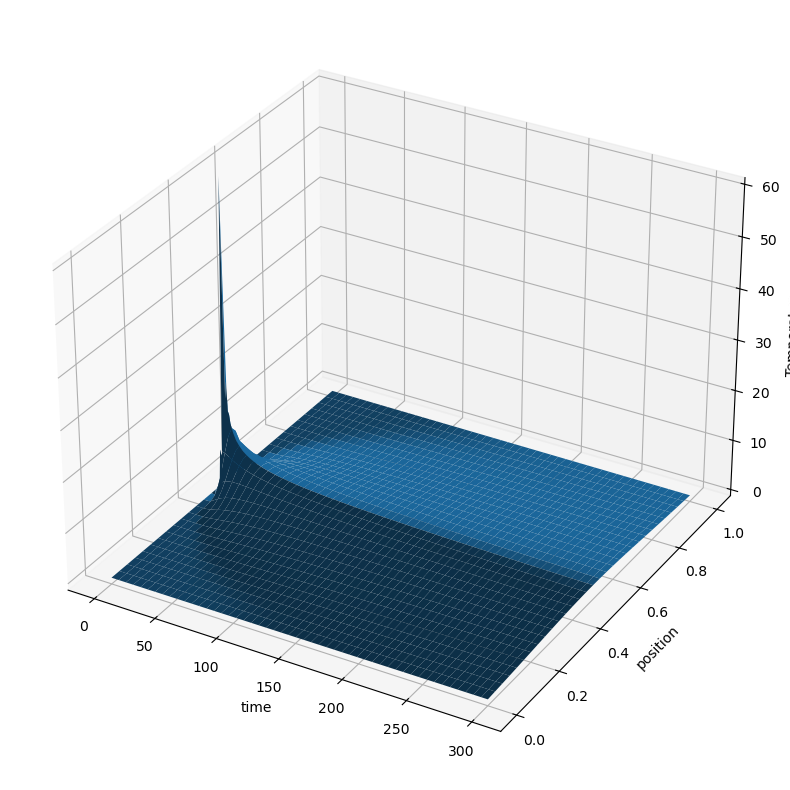

In [6]:
# Inputs for the diffusion equation
tau=1.e-4
N=61
L=1
kappa=1.0
tMax=300

# Make the spatial and time grids
x=np.linspace(0,L,N)
t=np.linspace(0,tMax,tMax)
Xp,Tp=np.meshgrid(x,t)

# Solve for the temperature distribution
Temp=solve_ftcs(tau,N,L,kappa,tMax)

# Make a 3D plot
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')
ax1.plot_surface(Tp,Xp,Temp)

ax1.set_xlabel('time')
ax1.set_ylabel('position')
ax1.set_zlabel('Temperature')

#plt.savefig('FTCS_diff.pdf',bbox_inches='tight')
plt.show()

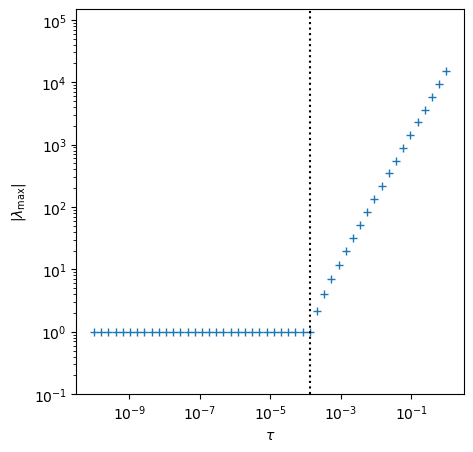

In [7]:
# Find the spectral radius

def spectral_radius(tau,kappa,N,L):
    
    # Construct D
    D=diags([1,-2,1],[-1,0,1],shape=(N,N)).toarray()
    D[0,:]=0.
    D[-1,:]=0.
    # Construct A
    A=np.identity(N)+(tau*kappa*(N/L)**2)*D
    
    # Find max eigenvalues
    return np.amax(np.absolute(np.linalg.eigvals(A)))

N=61
L=1.
kappa=1.
t_sig=(L/N)**2/(2*kappa)
taus=10**np.linspace(-10,0,50)


radii=[]
for tau in taus:
    radii.append(spectral_radius(tau,kappa,N,L))

fig1,ax1=plt.subplots(figsize=(5,5))
ax1.plot(taus,radii,'+')
ax1.plot([t_sig,t_sig],[np.amin(radii)/10,np.amax(radii)*10],'k:')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$\vert\lambda_{\rm max}\vert$')
ax1.set_ylim([np.amin(radii)/10,np.amax(radii)*10])
#print(radii)

plt.savefig('FTCS_diff_stability.pdf',bbox_inches='tight')
plt.show()